In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [2]:
import warnings 
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv("D:\\file ds\\exchange_rate.csv",header=0,index_col=0,parse_dates=True)
df.head()

,Ex_rate
date,
01-01-1990 00:00,0.7855
02-01-1990 00:00,0.7818
03-01-1990 00:00,0.7867
04-01-1990 00:00,0.7860
05-01-1990 00:00,0.7849


In [4]:
df.shape

(7588, 1)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7588 entries, 01-01-1990 00:00 to 10-10-2010 00:00
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Ex_rate  7588 non-null   float64
dtypes: float64(1)
memory usage: 118.6+ KB


In [6]:
df.isnull().sum()

Ex_rate    0
dtype: int64

In [7]:
# Linear interpolation for time series data
df['Ex_rate'] = df['Ex_rate'].interpolate(method='linear')


In [8]:
# Capping outliers
import numpy as np
upper_limit = df['Ex_rate'].quantile(0.99)
lower_limit = df['Ex_rate'].quantile(0.01)

df['Ex_rate'] = np.where(df['Ex_rate'] > upper_limit, upper_limit,
                               np.where(df['Ex_rate'] < lower_limit, lower_limit, df['Ex_rate']))


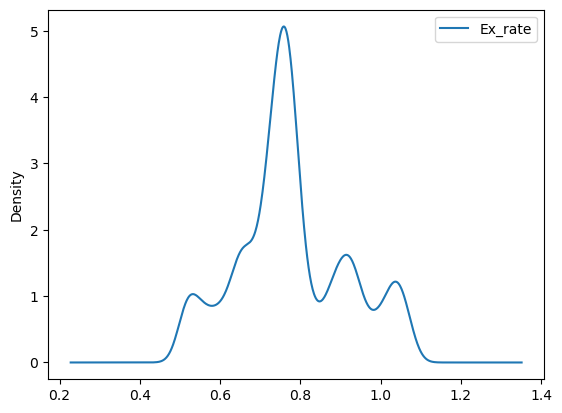

In [9]:
df.plot(kind='kde')
plt.show()

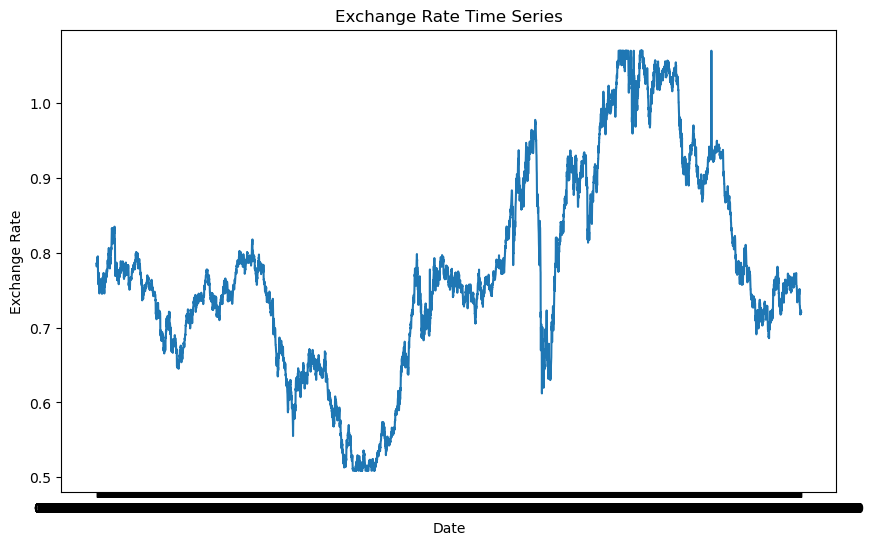

In [10]:
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['Ex_rate'])
plt.title('Exchange Rate Time Series')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
# plt.grid(True)
plt.show()

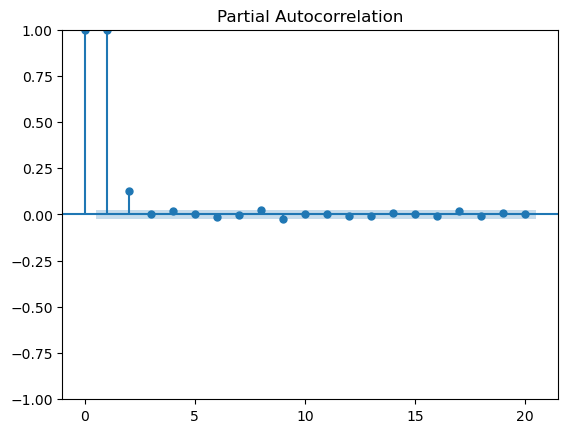

<Figure size 1000x900 with 0 Axes>

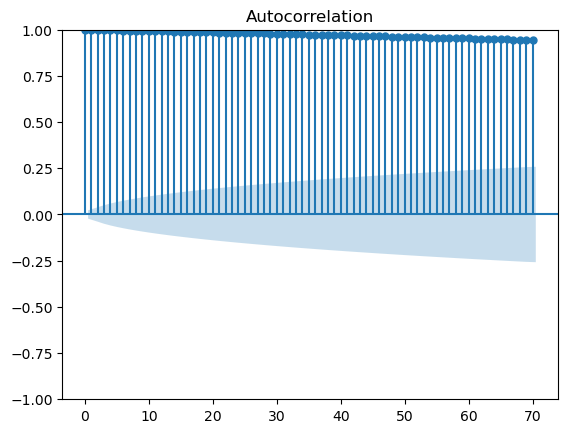

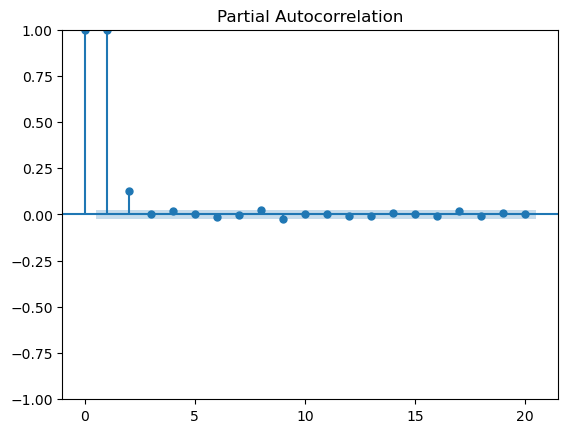

In [11]:
# 1. Parameter Selection for ARIM
plt.figure(figsize=(10,9))
plot_acf(df, lags=70)
plot_pacf(df, lags=20)

In [12]:
# # Based on ACF and PACF plots, select initial parameters (p, d, q)
p = 1
d = 1
q = 1


In [13]:
# Fit ARIMA model
model = ARIMA(df['Ex_rate'], order=(p, d, q))
model_fit = model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                Ex_rate   No. Observations:                 7588
Model:                 ARIMA(1, 1, 1)   Log Likelihood               28174.929
Date:                Sat, 21 Sep 2024   AIC                         -56343.859
Time:                        16:57:24   BIC                         -56323.056
Sample:                             0   HQIC                        -56336.720
                               - 7588                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1219      0.046     -2.648      0.008      -0.212      -0.032
ma.L1         -0.0080      0.046     -0.173      0.863      -0.098       0.082
sigma2      3.483e-05   1.01e-07    345.721      0.000    3.46e-05     3.5e-05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):           2331465.94
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.81   Skew:                             0.15
Prob(H) (two-sided):                  0.00   Kurtosis:                        88.88
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

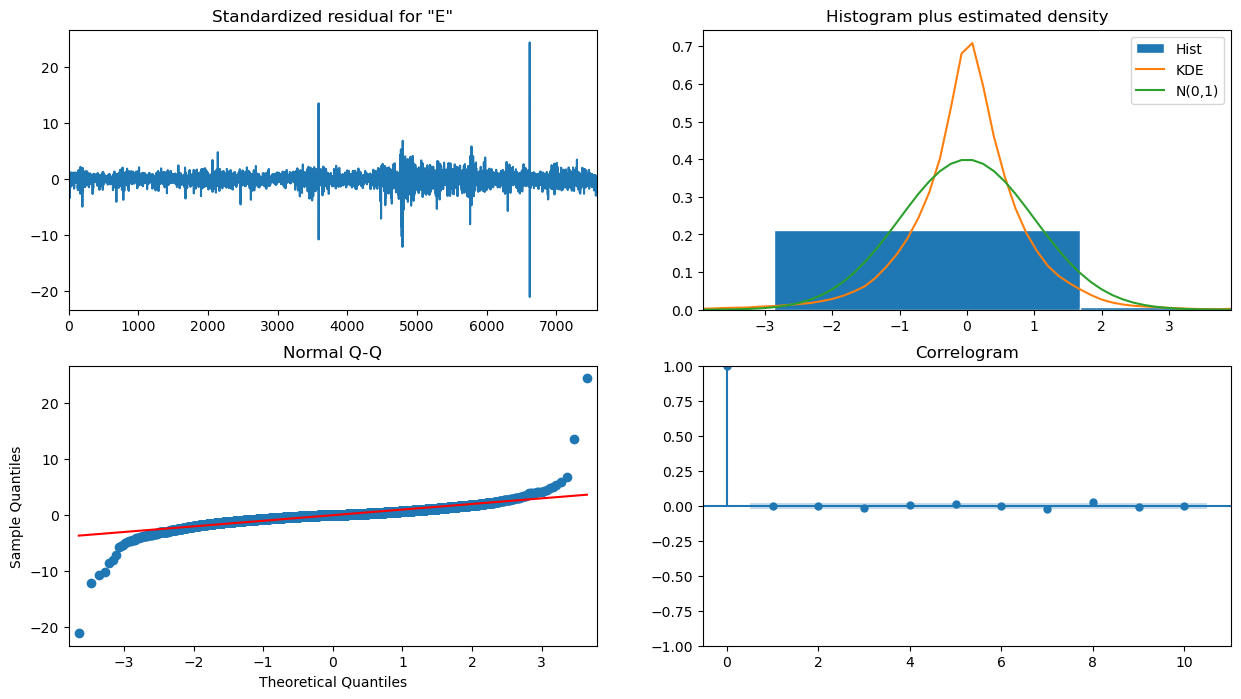

In [14]:
# Plot diagnostics
model_fit.plot_diagnostics(figsize=(15, 8))
plt.show()


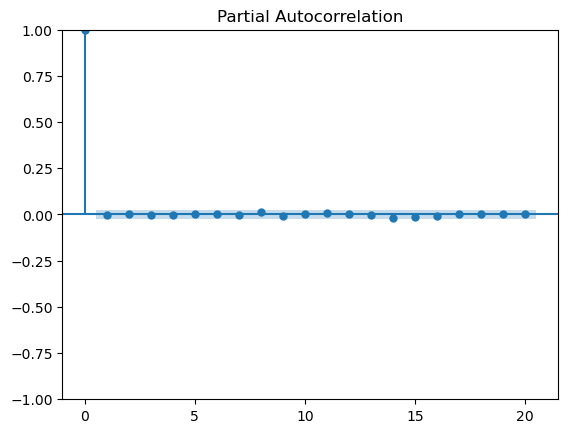

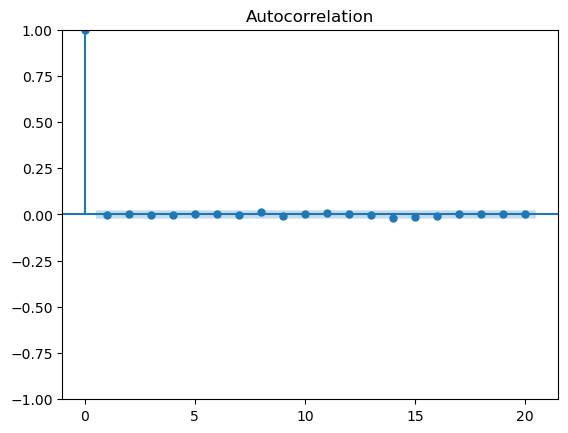

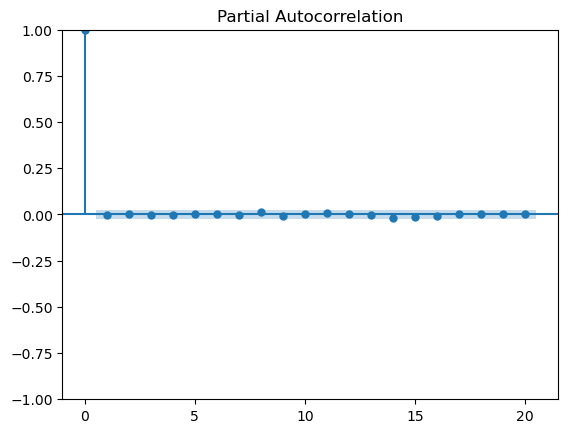

In [15]:
# Analyze residuals
residuals = model_fit.resid
plot_acf(residuals, lags=20)
plot_pacf(residuals, lags=20)

In [16]:
# Forecasting
forecast_steps = 30
forecast_result = model_fit.get_forecast(steps=forecast_steps)
forecast = forecast_result.predicted_mean
stderr = forecast_result.se_mean
conf_int = forecast_result.conf_int()

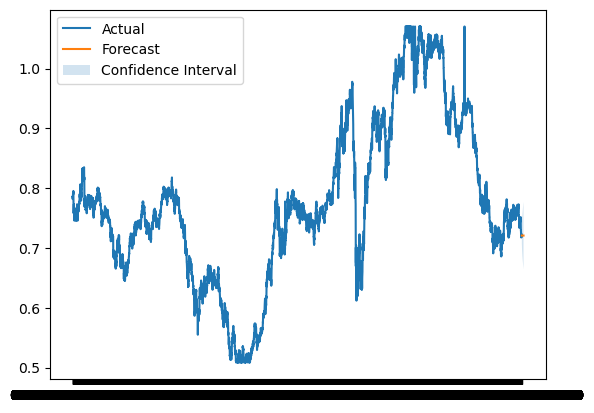

In [17]:
# Visualize forecast
plt.plot(df['Ex_rate'], label='Actual')
plt.plot(np.arange(len(df), len(df) + forecast_steps), forecast, label='Forecast')
plt.fill_between(np.arange(len(df), len(df) + forecast_steps), conf_int[conf_int.columns[0]], conf_int[conf_int.columns[1]], alpha=0.2, label='Confidence Interval')
plt.legend()
plt.show()

In [18]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt, ExponentialSmoothing


In [19]:
model = ExponentialSmoothing(df['Ex_rate'])
model_fit = model.fit()


In [20]:
forecast = model_fit.forecast(forecast_steps)


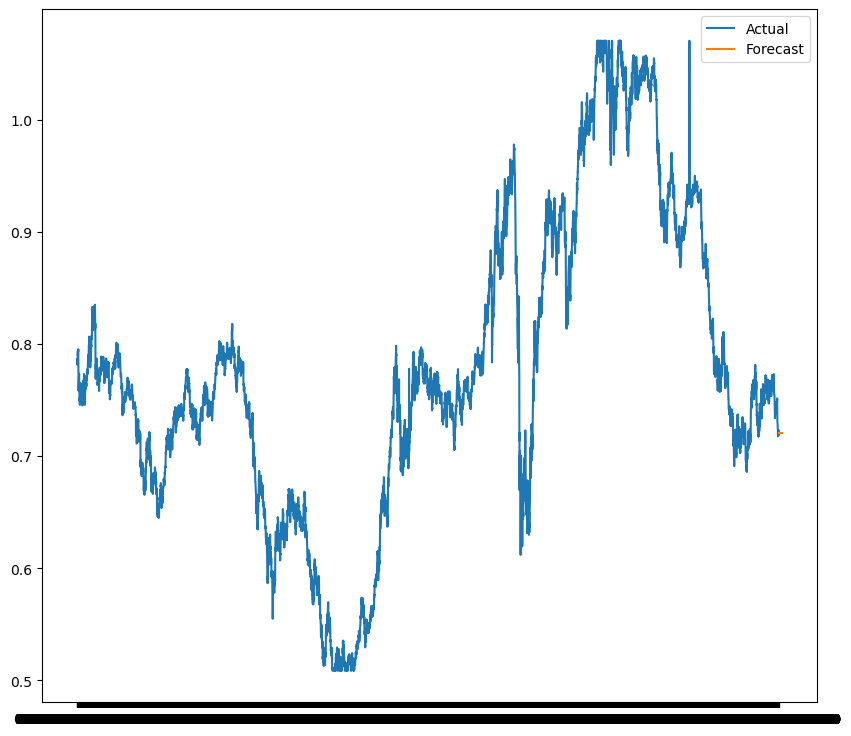

In [21]:
# Visualize forecast
plt.figure(figsize=(10,9))

plt.plot(df['Ex_rate'], label='Actual')
plt.plot(np.arange(len(df), len(df) + forecast_steps), forecast, label='Forecast')
plt.legend()
plt.show()

In [22]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
# Compute error metrics
mae_arima = mean_absolute_error(df['Ex_rate'], model_fit.forecast(steps=len(df)))
mae_es = mean_absolute_error(df['Ex_rate'], model_fit.forecast(steps=len(df)))


In [23]:
# Calculate metrics
mae = mean_absolute_error(df['Ex_rate'][-30:], forecast)
mse = mean_squared_error(df['Ex_rate'][-30:], forecast)
mape = mean_absolute_percentage_error(df['Ex_rate'][-30:], forecast)

# Print metrics
print('MAE:', mae)
print('MSE:', mse)
print('MAPE:', mape)

MAE: 0.012707819812973383
MSE: 0.00028758733504378586
MAPE: 0.017097577818457325
